# Setup

In [35]:
LOG_PLOT = False
NDAYS=100

In [36]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
from datetime import datetime
from ecdc import ECDC
ecdc = ECDC()
df = ecdc.df
print(ecdc.df.dateRep.max())
print(df.columns)
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


2020-11-16 00:00:00
Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')


# Overview

<IPython.core.display.Javascript object>


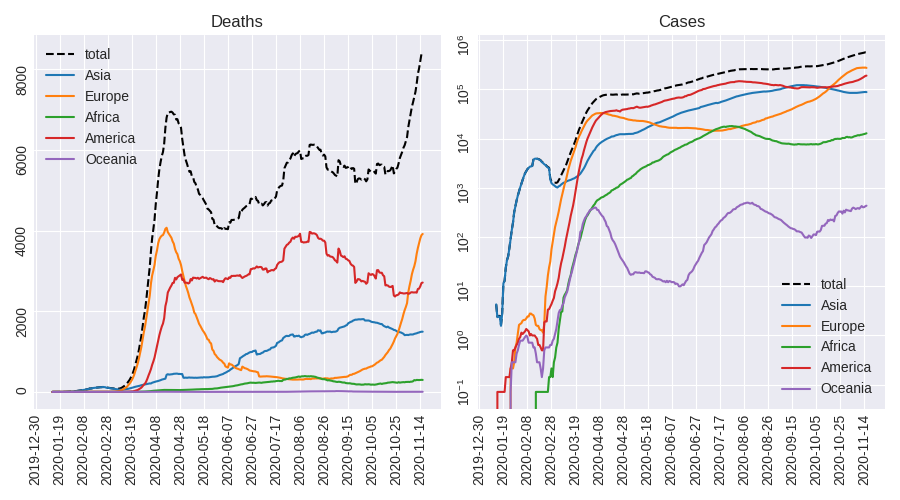

In [41]:
ecdc.overview(df).head(5)
f, ax = plt.subplots(ncols=2, figsize=(9,5), sharex=True)
deaths =ecdc.df.groupby('dateRep').agg({'deaths':'sum', 'cases': 'sum'})
ax[0].plot(deaths.index, deaths.deaths.rolling(14).mean(), label='total', c='k', linestyle='--')
ax[1].plot(deaths.index, deaths.cases.rolling(14).mean(), label='total', c='k', linestyle='--')
continents = ecdc.df.continentExp.unique()

for c in continents:
    if c=='Other': continue
    df_deaths =ecdc.df[ecdc.df.continentExp==c].groupby('dateRep').agg({'deaths':'sum', 'cases':'sum'})
    ax[0].plot(df_deaths.index, df_deaths.deaths.rolling(14).mean(), label=c.replace('_',' '))
    ax[1].plot(df_deaths.index, df_deaths.cases.rolling(14).mean(), label=c.replace('_',' '))
    
pretty_plot(ax[0], log=True,title='Deaths')
pretty_plot(ax[1], log=True,title='Cases')

# Austria, USA, India

<IPython.core.display.Javascript object>


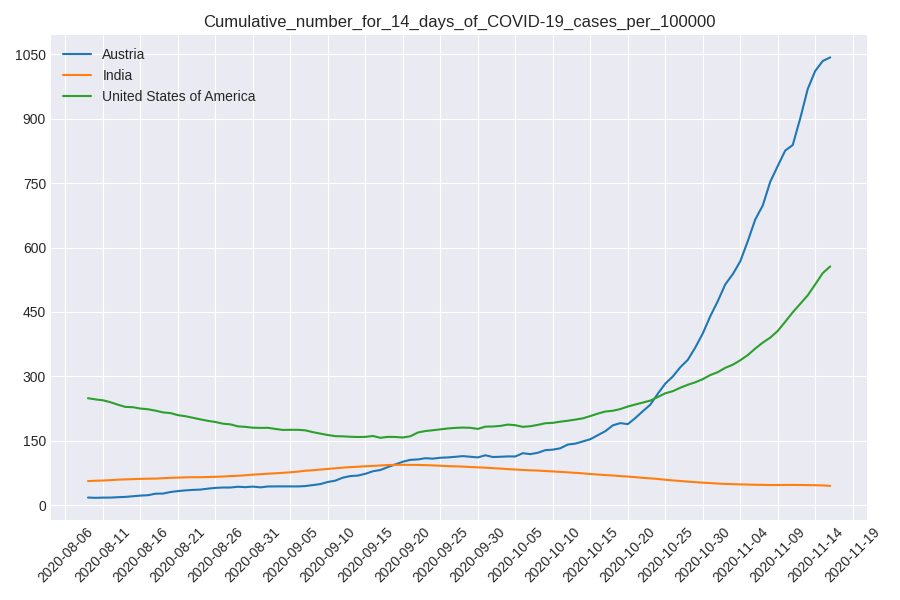

<IPython.core.display.Javascript object>


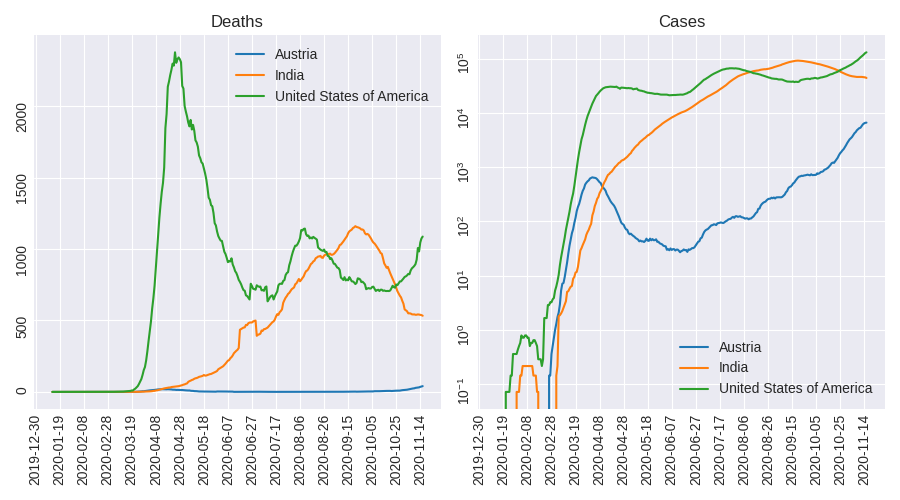

In [34]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ['AT', 'IN', 'US']
SELECTION =  ecdc.df[ecdc.df.geoId.isin(countries)]

ecdc.plot_comparison(countries, log=False, ndays=100)
ecdc.overview(SELECTION)
f,ax = plt.subplots(ncols=2, sharex=True, figsize=(9,5))
for c in countries:
    df = ecdc.select_country(c)
    popData2019 = df.iloc[0].popData2019
    label = df.iloc[0].countriesAndTerritories.replace('_',' ')

    ax[0].plot(df.dateRep, df.deaths.rolling(14).mean(), label=label)
    pretty_plot(ax[0],log=True, title='Deaths')
    ax[1].plot(df.dateRep, df.cases.rolling(14).mean(), label=label)
    pretty_plot(ax[1],log=True, title='Cases')



# Austria and Neighbours

In [59]:
EU[EU.countriesAndTerritories=='Slovenia']

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
46348,2020-11-16,16,11,2020,920,11,Slovenia,SI,SVN,2080908.0,Europe,931.948938
46349,2020-11-15,15,11,2020,1737,19,Slovenia,SI,SVN,2080908.0,Europe,952.228546
46350,2020-11-14,14,11,2020,1515,44,Slovenia,SI,SVN,2080908.0,Europe,955.111903
46351,2020-11-13,13,11,2020,1931,13,Slovenia,SI,SVN,2080908.0,Europe,969.048127
46352,2020-11-12,12,11,2020,2222,14,Slovenia,SI,SVN,2080908.0,Europe,995.911400
...,...,...,...,...,...,...,...,...,...,...,...,...
46599,2020-03-09,9,3,2020,4,0,Slovenia,SI,SVN,2080908.0,Europe,NaN
46600,2020-03-08,8,3,2020,3,0,Slovenia,SI,SVN,2080908.0,Europe,NaN
46601,2020-03-07,7,3,2020,3,0,Slovenia,SI,SVN,2080908.0,Europe,NaN
46602,2020-03-06,6,3,2020,5,0,Slovenia,SI,SVN,2080908.0,Europe,NaN


<IPython.core.display.Javascript object>


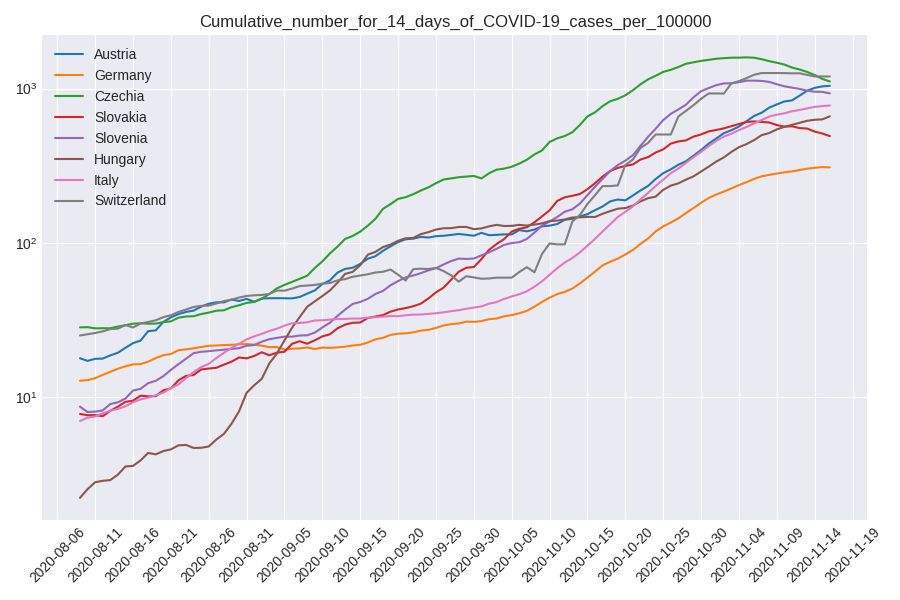

<IPython.core.display.Javascript object>


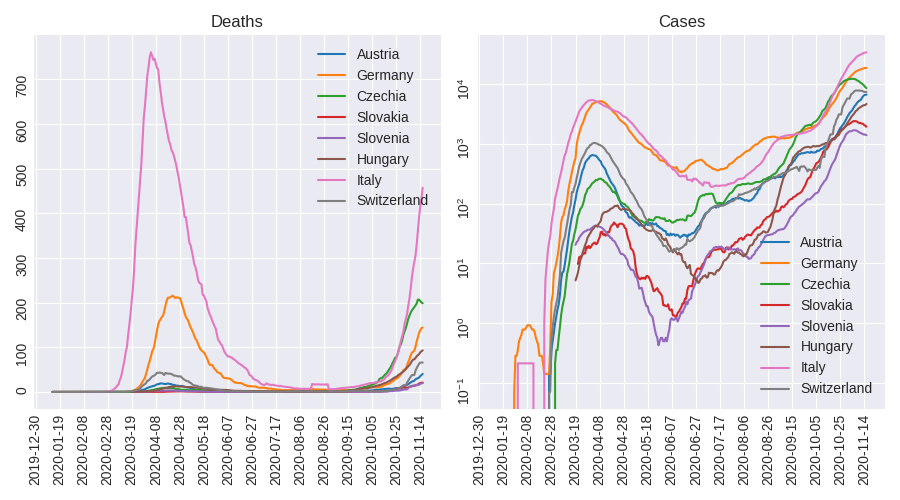

In [61]:
countries = ['AT', 'DE', 'CZ', 'SK',  'SI', 'HU', 'IT', 'CH']
ecdc.plot_comparison(countries, log=True, ndays=100)
f,ax = plt.subplots(ncols=2, sharex=True, figsize=(9,5))
for c in countries:
    df = ecdc.select_country(c)
    popData2019 = df.iloc[0].popData2019
    label = df.iloc[0].countriesAndTerritories.replace('_',' ')

    ax[0].plot(df.dateRep, df.deaths.rolling(14).mean(), label=label)
    pretty_plot(ax[0],log=True, title='Deaths')
    ax[1].plot(df.dateRep, df.cases.rolling(14).mean(), label=label)
    pretty_plot(ax[1],log=True, title='Cases')



# Scandinavia

<IPython.core.display.Javascript object>


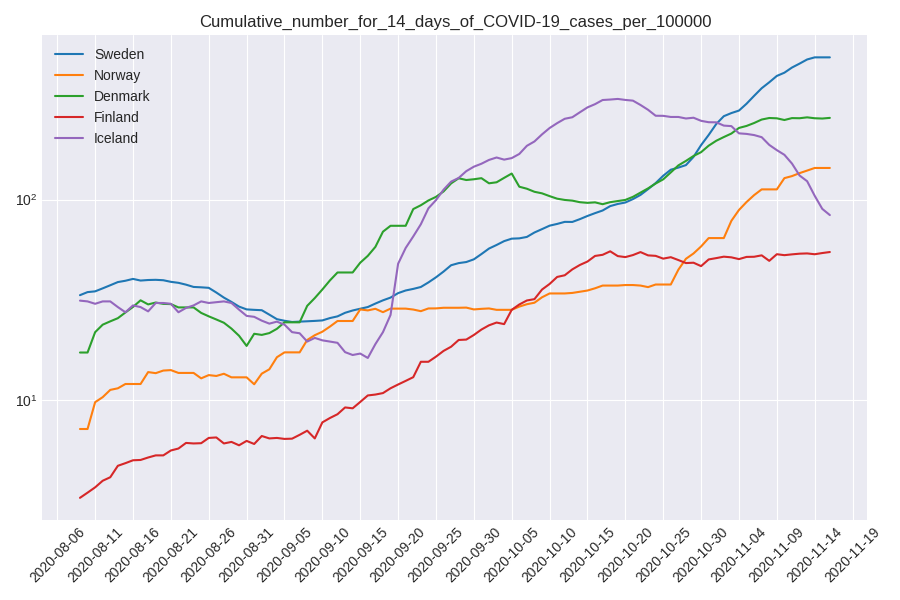

<IPython.core.display.Javascript object>


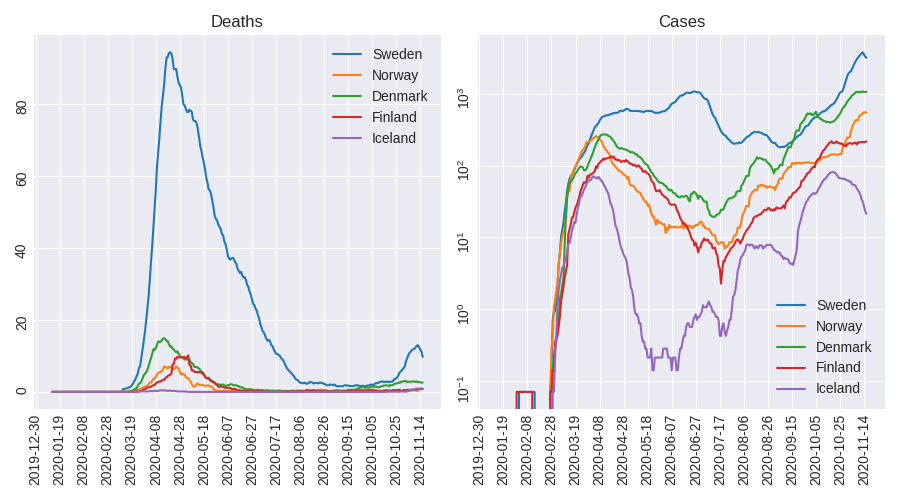

In [42]:
countries = ('SE','NO','DK','FI', 'IS')
ecdc.plot_comparison(countries, log=True, ndays=100)
f,ax = plt.subplots(ncols=2, sharex=True, figsize=(9,5))
for c in countries:
    df = ecdc.select_country(c)
    popData2019 = df.iloc[0].popData2019
    label = df.iloc[0].countriesAndTerritories.replace('_',' ')

    ax[0].plot(df.dateRep, df.deaths.rolling(14).mean(), label=label)
    pretty_plot(ax[0],log=True, title='Deaths')
    ax[1].plot(df.dateRep, df.cases.rolling(14).mean(), label=label)
    pretty_plot(ax[1],log=True, title='Cases')



# Europe

<IPython.core.display.Javascript object>


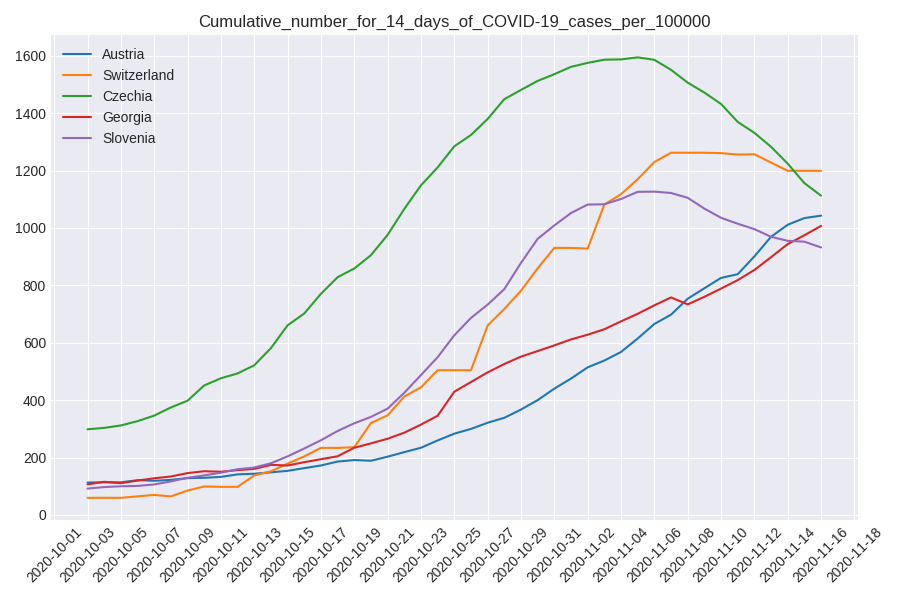

<IPython.core.display.Javascript object>


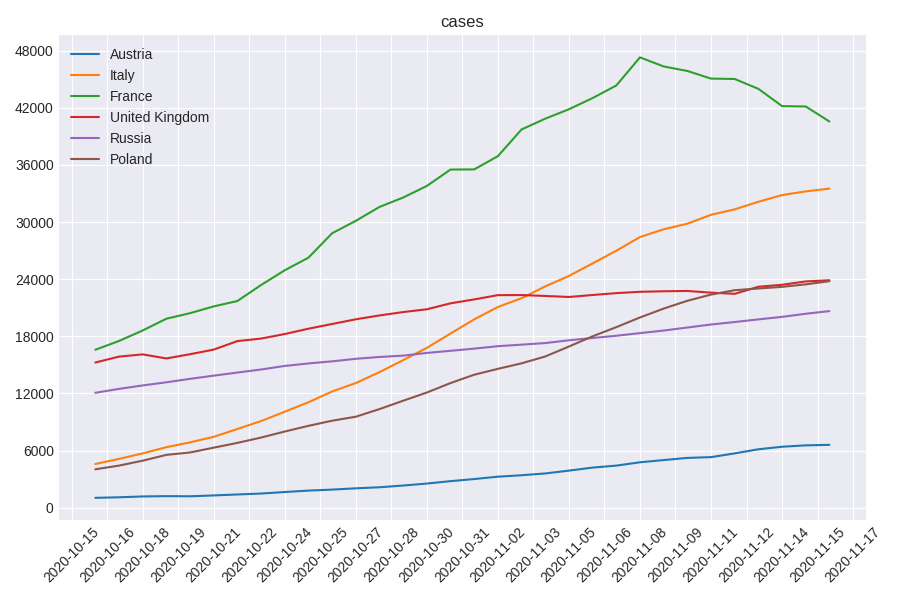

<IPython.core.display.Javascript object>


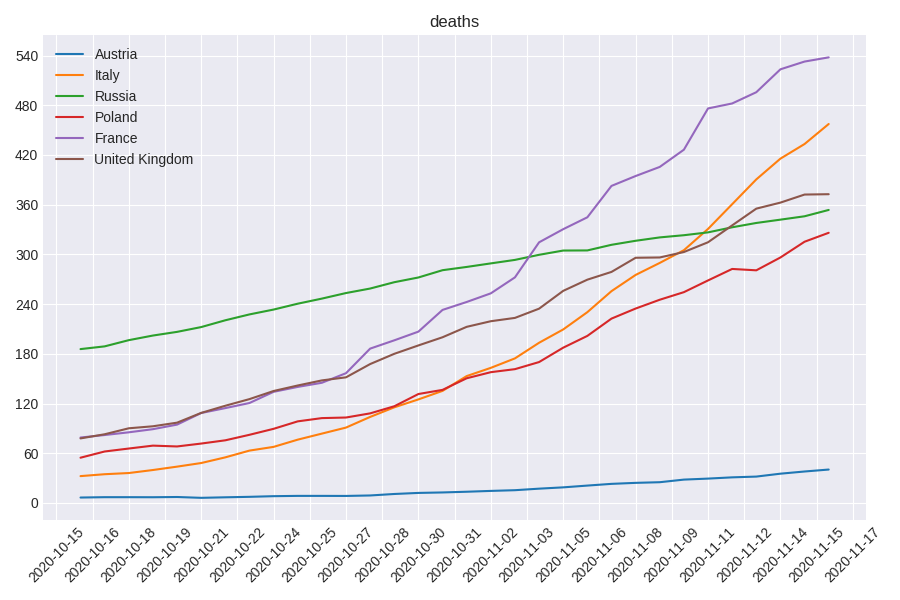

In [48]:
EU_med = EU[EU.popData2019>1000000]
ecdc.overview(EU_med).sort_values(by=('Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', 'latest'), ascending=False).head(5)
EU_most = EU_med.sort_values(['dateRep', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'], ascending=[False,False]).head(10)
geoIds = EU_med.sort_values(['dateRep', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'], ascending=[False,False]).head(5).geoId.to_list()
geoIds = sorted(set(['AT', *geoIds ]))
ecdc.plot_comparison(geoIds, log=False, ndays=45, field='Cumulative_number_for_14_days_of_COVID-19_cases_per_100000');

geoIds = EU_med.sort_values(['dateRep', 'cases'], ascending=[False,False]).head(5).geoId.to_list()
ecdc.plot_comparison(['AT', *geoIds ], log=False, ndays=45, field='cases', roll_days=14);

geoIds = EU_med.sort_values(['dateRep', 'deaths'], ascending=[False,False]).head(5).geoId.to_list()
ecdc.plot_comparison(['AT', *geoIds ], log=False, ndays=45, field='deaths', roll_days=14);

